# Few Shot Learning- Training

**Notebook內容：**
1. 資料探索與資料讀取
2. 模型訓練
3. 預測&評估
4. 練習
5. 參考資料(連結+連結說明)

延續上一份教材，我們已經之知道Few shot learning的model有哪些，那這邊我沒會把model與配合的訓練框架組裝起來

## 1.資料探索與資料讀取

In [1]:
!git clone https://github.com/DeepStudio-TW/small-data-ssl-lecture.git
!cd small-data-ssl-lecture

fatal: destination path 'small-data-ssl-lecture' already exists and is not an empty directory.


In [5]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/uc?id=1XagZtTeUhFWiXvlZabja0XJhBMwQFl6j&export=download
# Unzip the files
!tar zxf  mnistm_half.tar.gz

### 1.1 範例內容
* 資料來源: 
    * Source: [MNIST-M](https://paperswithcode.com/dataset/mnist-m) 0~9 數字圖片混入BSDS500照片資料庫背景
    * Target: [MNIST](http://yann.lecun.com/exdb/mnist/) 0~9 數字圖片資料

* Label: 
    * Source data label 0~9
    * target data label 0~9
    * test data不使用 label訓練，純粹驗證用

In [1]:
# 讀取基本套件
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch

In [2]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

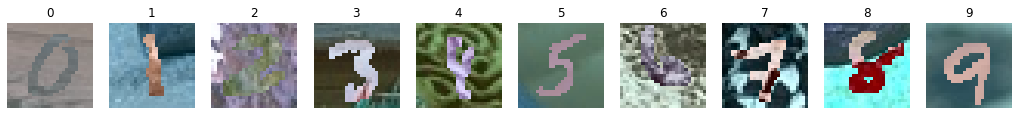

In [3]:
# 看source data: 
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
example_files=[glob(f"mnistm_half/mnist_m_test/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

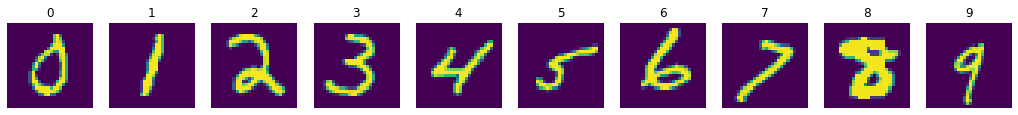

In [4]:
# 看target data
example_files=[glob(f"mnistm_half/mnist_train/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

### 1.2 Data Loader設計
這邊我們三個loader
* source: 來源資料集，有MNIST圖片，也有對應的label
* target: 目標資料集，只有少量MNIST-M 圖片，也有對應的label
* test: 測試資料集，有MNIST-M圖片，也有對應的label

Data Loader的要件:
* dataset: torchvision的VisionDataset，我們這邊使用ImageFolder作，只要把圖片依照分類放進資料夾就能依照資料夾名稱指定分類：
```
data_root
|--class 1
|   |--image 1
|   |--image 2
|   ...
|--class 2
|   |--image 3
...
```
* transform: augmentation function，這邊使用torchvision.transforms來做，也推薦[cv2 wrapaffine](https://theailearner.com/tag/cv2-warpaffine/)或者[aubmentation](https://github.com/albumentations-team/albumentations)，因為這是Deep Learning CV的基本所以這邊不多贅述。

* Transfer Learning Methods用的Loader:

In [5]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds

train_transform = tvt.Compose([
    tvt.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
])
test_transform = tvt.Compose([
    tvt.ToTensor(),
])

# Source套用source的transform
source_dataset = tvds.ImageFolder('mnistm_half/mnist_m_train', transform=train_transform)
# Target套用target的transform
target_dataset = tvds.ImageFolder('mnistm_half/mnist_train', transform=train_transform)
# Testing與Target那邊一樣資料，但會把label拿起來算準確度
test_dataset = tvds.ImageFolder('mnistm_half/mnist_test', transform=test_transform)

In [6]:
tgt_classes=glob("mnistm_half/mnist_train/*/")

In [7]:
tgt_classes

['mnistm_half/mnist_train/8/',
 'mnistm_half/mnist_train/1/',
 'mnistm_half/mnist_train/6/',
 'mnistm_half/mnist_train/2/',
 'mnistm_half/mnist_train/9/',
 'mnistm_half/mnist_train/5/',
 'mnistm_half/mnist_train/7/',
 'mnistm_half/mnist_train/4/',
 'mnistm_half/mnist_train/3/',
 'mnistm_half/mnist_train/0/']

In [8]:
WAYS=10
SHOTS=5

使用Sampler可以抽特定class固定數量的資料

In [9]:
from torch.utils import data as tud
from supp.fsl_dataset import FewShotSampler

* dataloader: torch 本身的dataloader class，可以將上述loader的function做batching，以及安排shuffle和多線程等動作

In [10]:
from torch.utils.data import DataLoader
# source跟target都使用小batch size
BS_TRAIN=32
BS_TEST=128
source_dataloader=DataLoader(source_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=True)


sampler=FewShotSampler(target_dataset,target_dataset.classes,SHOTS,repeats=100)
target_dataloader=DataLoader(target_dataset, 
                    batch_size=WAYS*SHOTS,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True,
                    sampler=sampler)


# test dataset因為沒有gradient紀錄，GPU記憶體用量較小，所以可以開大一點batch size
test_dataloader = DataLoader(test_dataset,
                batch_size=BS_TEST,
                shuffle=False,
                num_workers=2,
                pin_memory=True)

## 2.模型訓練

### 2.1 Training Loss& Optimizer
可以當成一般分類問題來給訂相關loss、optimizer

**Loss function(criterion)**
* CCE: nn.CrossEntropyLoss給label predictor output用
* BCE: nn.BCEWithLogitsLoss給domain classifier output用

In [11]:
from torch import nn
from supp.nn_model import (FeatureExtractor,Baseline,MetricLayer,cosine,
                    FocalLoss,AddMarginLoss,ArcMarginLoss)
#@title Hyper Parameters
#@markdown Latent space dimension
latent_dims=16 #@param
#@markdown Model (transfer learning): export model=ModelClass(*args)
model_type="baseline++" #@param ["baseline","baseline++"]
if model_type=="baseline":
    head=nn.Linear(latent_dims,WAYS)
elif model_type=="baseline++":
    head=MetricLayer(latent_dims,WAYS,cosine)   
else:
    print("unrecognizable head")
backbone=FeatureExtractor(latent_features=latent_dims)
model=Baseline(WAYS,backbone,head).cuda()
#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="arcmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")



**Optimizer**
* 這邊使用Adam來作optimization，且三個子模型要分開，因為每個訓練step會有兩個部分:
    * 訓練domain classifier
    * 訓練label predictor+feature extractor

In [12]:
import torch.optim as optim
# 為了方便我們令一個class可以直接把dictionary key變成其attribute (可以直接用d.key)
lr=0.001
optimizer=optim.Adam(model.parameters(),lr=lr)

若有調整model可以看一下summary確定axis數、每個axis維度是否如預期

In [15]:
# !pip install torchsummary
# from torchsummary import summary
# summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
    InstanceNorm2d-2         [-1, 64, 224, 224]               0
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
              conv-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
    InstanceNorm2d-7        [-1, 128, 112, 112]               0
              ReLU-8        [-1, 128, 112, 112]               0
         MaxPool2d-9          [-1, 128, 56, 56]               0
             conv-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
   InstanceNorm2d-12          [-1, 256, 56, 56]               0
             ReLU-13          [-1, 256, 56, 56]               0
        MaxPool2d-14          [-1, 256,

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 2.2 Training Parameters& Callbacks

**Parameters**
- EPOCHS: 先設一個很大的數，當訓練不下去時也可以手動停止
- DISC_LOOPS: Discrimination可以比較多次一點，增加Discriminator強度

**Callbacks**
- Learning rate scheduling: ReduceLROnPlateau-模型訓練不下去時learning rate減少


In [16]:
EPOCHS=5
# For scheduler
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### 2.3 Source data Training

In [17]:
from tqdm.notebook import tqdm
def train_epoch(epoch,model,criterion,optimizer,dataloader,adapt=False):
    running_loss = 0.0 # Feature Extrator & Label Predictor的loss
    total_hit, total_num = 0.0, 0.0 # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    session=tqdm(enumerate(dataloader))
    for i, (data, label) in session:
        data = data.cuda()
        label = label.cuda()

        # 訓練整個model
        if not adapt:
            class_logits = model(data)
        # Adaptation時不訓練backbone
        else:
            with torch.no_grad():
                latent = model.backbone(data)
            # 不訓練backbone
            class_logits=model.head(latent.detach())
        # loss以指定的為主
        loss = criterion(class_logits, label)
        loss.backward()
        
        optimizer.step()
        # scheduler.step(loss) # For scheduler
        optimizer.zero_grad()

        running_loss+= loss.item()
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
        total_num += data.shape[0]

        session.set_postfix({"epoch":epoch,"loss":loss.item(),"acc":total_hit / total_num})
    return running_loss / (i+1), total_hit / total_num

In [18]:
# 訓練 Source
try:
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_dataloader,adapt=False)
        torch.save(model.state_dict(), f'{model_type}_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

## 3.預測&評估

### 3.1 Evaluating Before Adaptation

In [19]:
def run_test(model,data_loader):
    result = []
    total_test_hit, total_test_num = 0.0, 0.0
    with torch.no_grad():
        for i, (data,label) in enumerate(data_loader):
            test_data = data.cuda()
            test_label = label.cuda()

            class_logits = model(test_data)

            pred = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
            result.append(pred)
            total_test_hit += torch.sum(torch.argmax(class_logits, dim=1) == test_label).item()
            total_test_num += test_data.shape[0]

    print("test acc:",total_test_hit / total_test_num)
    return result,total_test_hit / total_test_num

In [20]:
pred=run_test(model,test_dataloader)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


test acc: 0.2312


### 3.2 Target data Training

In [21]:
#@title Target Model Head
#@markdown Model (transfer learning): export model_tgt=ModelClass(old_backbone,new_head)
model_type="baseline++" #@param ["baseline","baseline++"]
if model_type=="baseline":
    head_tgt=nn.Linear(latent_dims,WAYS)
elif model_type=="baseline++":
    head_tgt=MetricLayer(latent_dims,WAYS,cosine)
else:
    print("unrecognizable head")
model_tgt=Baseline(WAYS,backbone,head_tgt).cuda()
#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="arcmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion_tgt = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion_tgt = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion_tgt = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion_tgt = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")
model_tgt.backbone.eval()
optimizer_tgt=optim.Adam(model_tgt.parameters(),lr=lr*10)

In [22]:
# Random Inspect parameters before fine-tuning
[*backbone.blocks[2].parameters()][-1][:20]

tensor([-0.0143, -0.0308,  0.0201,  0.0254,  0.0374, -0.0444, -0.0109, -0.0772,
         0.0230, -0.1002, -0.0286,  0.0213, -0.0243, -0.0155,  0.0190, -0.0371,
         0.0145, -0.0065,  0.0744,  0.0237], device='cuda:0',
       grad_fn=<SliceBackward>)

In [23]:
# 訓練 target
try:
    train_loss, train_acc = train_epoch(epoch,model_tgt,criterion_tgt,optimizer_tgt,target_dataloader,adapt=True)
    torch.save(model.state_dict(), f'{model_type}_{loss_type}_adapted.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

In [24]:
# Random Inspect parameters after fine-tuning
[*backbone.blocks[2].parameters()][-1][:20]

tensor([-0.0143, -0.0308,  0.0201,  0.0254,  0.0374, -0.0444, -0.0109, -0.0772,
         0.0230, -0.1002, -0.0286,  0.0213, -0.0243, -0.0155,  0.0190, -0.0371,
         0.0145, -0.0065,  0.0744,  0.0237], device='cuda:0',
       grad_fn=<SliceBackward>)

In [25]:
pred=run_test(model_tgt,test_dataloader)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


test acc: 0.9232


## 4.練習

1. 這次練習的是使用雜色的MNIST-M做source，MNIST作為target訓練，請試著把兩個資料集倒過來
2. 嘗試不同的source training組合:
    - baseline & cce, baseline & focal loss
    - baseline++ & cce, baseline++ & addmargin loss
3. 嘗試不同target training組合:
    - baseline(其實只換了head) & cce, baseline & focal loss
    - baseline++(其實只換了head) & cce, baseline++ & arcmargin loss
3. 嘗試減少latent space的dimension，試著調整其他超參數優化模型準確度
4. 將target way數, shot數改變為5way 5 shot，試著調整其他超參數優化模型準確度


## 5.參考資料

* [Chen, W. Y., Liu, Y. C., Kira, Z., Wang, Y. C. F., & Huang, J. B. (2019). A closer look at few-shot classification. arXiv preprint arXiv:1904.04232.](https://arxiv.org/abs/1904.04232)
    - Baseline++ 原文(台大王鈺強老師團隊)
* [Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal loss for dense object detection. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988). ](https://arxiv.org/abs/1708.02002v2)
    - Focal Loss原文
* [Wang, H., Wang, Y., Zhou, Z., Ji, X., Gong, D., Zhou, J., ... & Liu, W. (2018). Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 5265-5274).](https://arxiv.org/abs/1801.09414)
    - CosineFace原文
* [Deng, J., Guo, J., Xue, N., & Zafeiriou, S. (2019). Arcface: Additive angular margin loss for deep face recognition. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 4690-4699).](https://arxiv.org/abs/1801.07698)
    - ArcFace原文